# Instruction-Tuning Open LLaMa through QLoRA on Dolly 15k Dataset

**Resources:**
- [Transformer Reinforcement Learning](https://github.com/lvwerra/trl)
- [Bitsandbytes](https://github.com/TimDettmers/bitsandbytes)
- [HuggingFace](https://github.com/huggingface)
- [Dolly 15k](https://huggingface.co/datasets/databricks/databricks-dolly-15k)
- [Source Repository](https://github.com/FourthBrain/Building-with-Instruction-Tuned-LLMs-A-Step-by-Step-Guide)

In [17]:
# Import Standard Libraries
import torch
import transformers

from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

# Read Data

In [3]:
# Read data from HuggingFace Dolly 15k
data = load_dataset('databricks/databricks-dolly-15k')

Found cached dataset json (/Users/s.porreca/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-6e0f9ea7eaa0ee08/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

Each row is composed by:
- Instruction
- Context (optional)
- Response
- Category (e.g. Creative Writing, Close QA, etc.)

# Exploratory Data Analysis (EDA)

## Inspect Sequence Length

In [5]:
# Define the max length for each sequence
sequence_length_threshold = 2200

In [6]:
# Initialise empty variables for length
sequence_lengths, index_too_long_sequences = [], []

# Retrieve the length of each sequence in the dataset
for index, sequence in enumerate(data['train']):
    
    # Compute length
    sequence_length = len(sequence['instruction']) + len(sequence['context']) + len(sequence['category'])
    
    # Append the length
    sequence_lengths.append(sequence_length)
    
    # Add sequence to the list of too long ones
    if sequence_length > sequence_length_threshold:
        
        index_too_long_sequences.append(index)

## Sequence Length Distribution

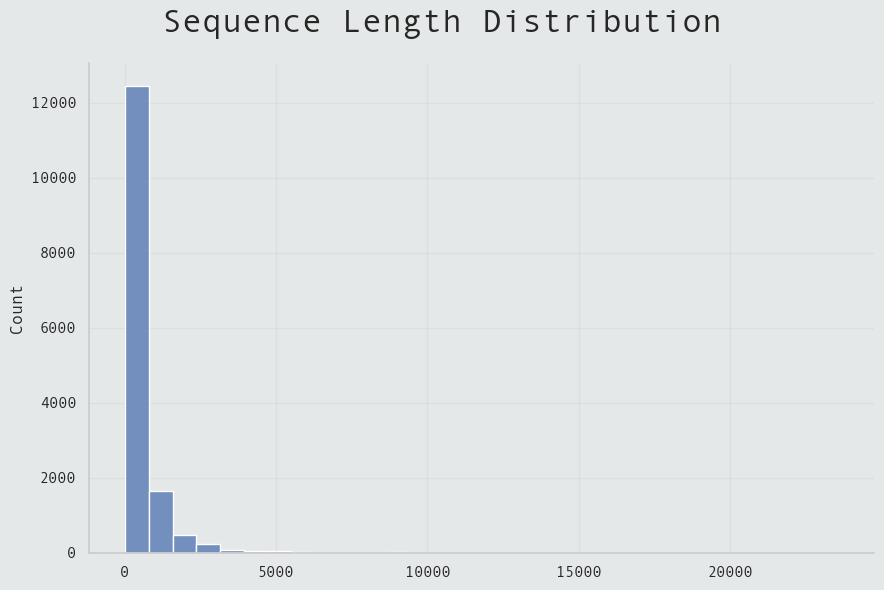

In [7]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(9, 6))

# Plot histogram
sns.histplot(data=sequence_lengths, bins=30)

# Set figure Title
figure.suptitle('Sequence Length Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

Most of the sequence have a short length.

# Data Preparation

## Filter Data based on Sequence Length

In [8]:
# Filter the data that are not too long
filtered_data = data.filter(lambda row, index: index not in index_too_long_sequences, with_indices=True)

Loading cached processed dataset at /Users/s.porreca/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-6e0f9ea7eaa0ee08/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-89ad7f2ae71bc24d.arrow


In [9]:
# Initialise empty list for sequence lengths
sequence_lengths = []

# Retrieve the length of each sequence in the filtered dataset
for index, sequence in enumerate(filtered_data['train']):
    
    # Compute length
    sequence_length = len(sequence['instruction']) + len(sequence['context']) + len(sequence['category'])
    
    # Append the length
    sequence_lengths.append(sequence_length)

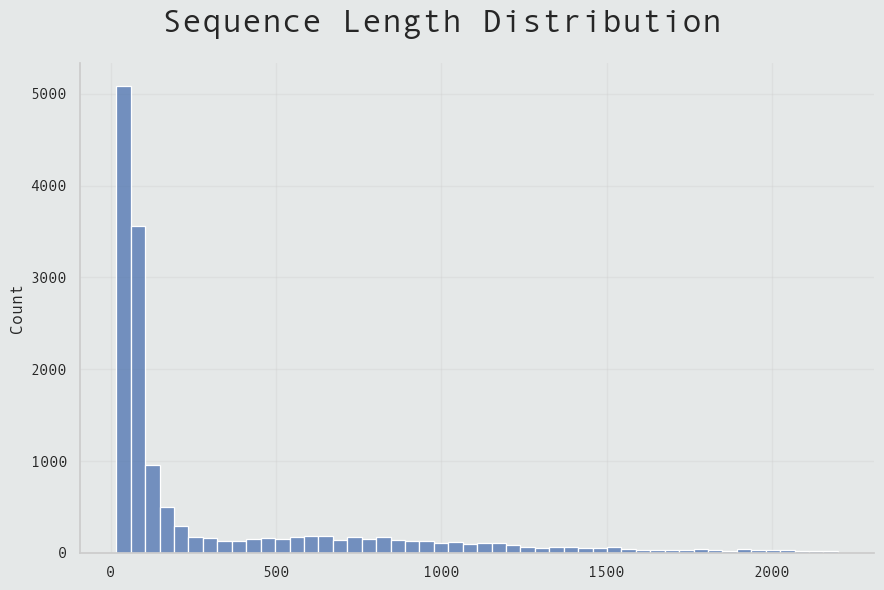

In [10]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(9, 6))

# Plot histogram
sns.histplot(data=sequence_lengths, bins=50)

# Set figure Title
figure.suptitle('Sequence Length Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

## Train & Test Split

In [11]:
# Split data into train and test
prepared_data = filtered_data['train'].train_test_split(test_size=0.1)

## Format Samples

In [12]:
def format_sample(sample):
    """
    Format the sample in a proper string for the training phase
    """
    
    # Initialise empty prompt
    prompt = []
    
    # Switch for samples with no context
    if sample['context'] == '':
        prompt.append('Below is an instruction that describes a task.')
        prompt.append('Write a response that appropriately completes the request.\n')
        prompt.append('### Instruction:')
        prompt.append(f"{sample['instruction']}\n")
        prompt.append('### Response:')
        prompt.append(f"{sample['response']}")
    else:
        prompt.append('Below is an instruction that describes a task, paired with an input that provides further context.')
        prompt.append('Write a response that appropriately completes the request.\n')
        prompt.append('### Instruction:')
        prompt.append(f"{sample['instruction']}\n")
        prompt.append('### Context:')
        prompt.append(f"{sample['context']}\n")
        prompt.append('### Response:')
        prompt.append(f"{sample['response']}")
        
    return {'text': '\n'.join(prompt)}

In [13]:
print(format_sample(prepared_data['train'][0])['text'])

Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
What NFL team was moved out of Ohio and became the Baltimore Ravens in 1996?

### Response:
The owner of the Cleveland Browns, Art Modell, decided to relocate the team from Cleveland to Baltimore. However, a settlement decided that the titles, history, and colors would stay in Cleveland and the personnel and team were moved to Baltimore. Cleveland was without a football team from 1996 until replacements were established in 1999.


In [14]:
# Format data
formatted_data = prepared_data.map(format_sample)

Map:   0%|          | 0/13045 [00:00<?, ? examples/s]

Map:   0%|          | 0/1450 [00:00<?, ? examples/s]

# Load Model

In [ ]:
# Define the model checkpoint
model_id = "openlm-research/open_llama_7b_700bt_preview"